<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
# Is there any missing data?
walmart.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [4]:
# What are the column datatypes?
walmart.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [5]:
# How many observations are there?
walmart.shape

(421570, 5)

In [6]:
# How many unique stores are there?
walmart['Store'].nunique()

45

In [7]:
# How many unique departments are there?
walmart['Dept'].nunique()

81

**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [8]:
walmart['Date'] = pd.to_datetime(walmart['Date'])

In [9]:
walmart.set_index('Date', inplace=True)

In [10]:
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [11]:
# Data look before filtering
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [12]:
# Weekly aggregate data of store 1
walmart = walmart[walmart['Store'] == 1].groupby('Date').sum()\
.drop(columns=['Store', 'Dept', 'IsHoliday'])

In [13]:
# Data look after filtering
walmart.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

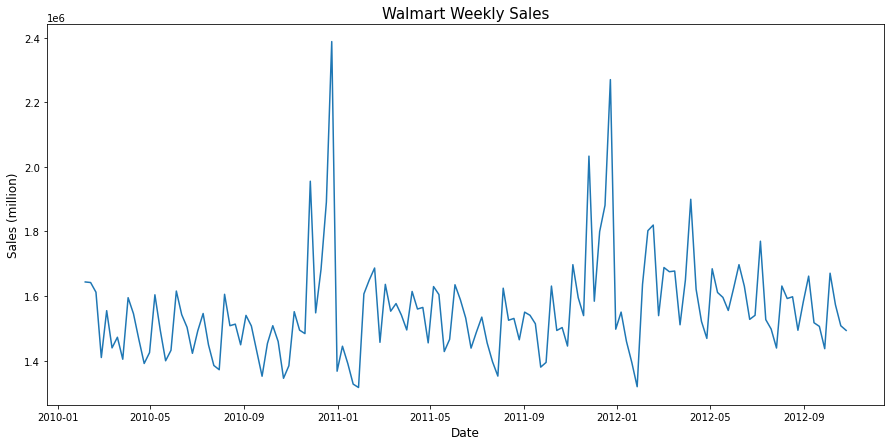

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(walmart)
plt.title('Walmart Weekly Sales', fontsize=15)
plt.ylabel('Sales (million)', fontsize=12)
plt.xlabel('Date', fontsize=12);

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

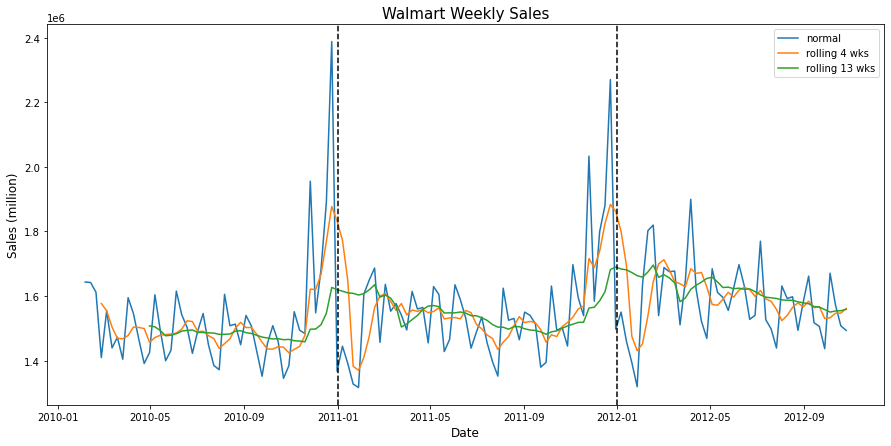

In [15]:
plt.figure(figsize=(15, 7))

# plot
plt.plot(walmart, label='normal')
plt.plot(walmart.rolling(4).mean(), label='rolling 4 wks')
plt.plot(walmart.rolling(13).mean(), label='rolling 13 wks')

# add vertical lines
plt.axvline(pd.Timestamp('2011-01-01'), color='black', linestyle='--')
plt.axvline(pd.Timestamp('2012-01-01'), color='black', linestyle='--')

# add other elements
plt.title('Walmart Weekly Sales', fontsize=15)
plt.ylabel('Sales (million)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend();

**Describe any trends that you notice**

In [16]:
# Data seem to have seasonality from very high amount of sale 
# near end of year 2011 and 2012.

# The reason of peak sales in the end of year would be Christmas Day
# and New Year celebrations.

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

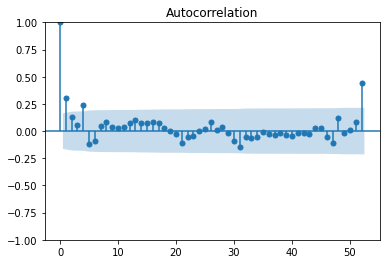

In [17]:
plot_acf(walmart, lags=52);

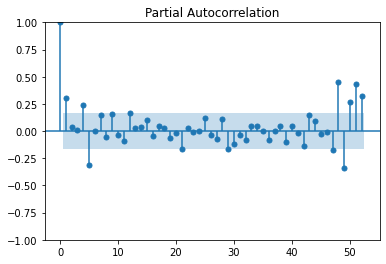

In [18]:
plot_pacf(walmart, lags=52);

In [19]:
# From ACF plot, positive autocorrelation could be spotted for 
# lag of 1 week, 4 weeks and also stronger autocorrelation occure 
# at week 52, which equal to 1 year.

# From partial autocorrelation, many spots show sinificant values both
# positive and negative at first 5 lags and last 5 lags.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [20]:
train, test = train_test_split(walmart, test_size=0.1, 
                               shuffle=False, random_state=42)

In [21]:
# check split size
train.shape, test.shape

((128, 1), (15, 1))

In [22]:
# train tail and test head
train.tail()

,Weekly_Sales
Date,
2012-06-15,1630607.00
2012-06-22,1527845.81
2012-06-29,1540421.49
2012-07-06,1769854.16
2012-07-13,1527014.04


In [23]:
test.head()

,Weekly_Sales
Date,
2012-07-20,1497954.76
2012-07-27,1439123.71
2012-08-03,1631135.79
2012-08-10,1592409.97
2012-08-17,1597868.05


**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [24]:
# Create funciton to filter only needed test outputs
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2],
                        index=['Test Statistic', 'p-value'])
    return dfoutput

In [25]:
# Run ADF test
interpret_dftest(adfuller(walmart))

Test Statistic   -5.102186
p-value           0.000014
dtype: float64

In [26]:
## From the result, p-value less than 0.05, which means we can reject h0
## and our data is stationary.

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [27]:
# Instantiate ARIMA model
arima = ARIMA(endog=train, order=(1, 0, 0))

# Fit model
model = arima.fit()

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [28]:
train_preds = model.predict(start=train.index[0], end=train.index[-1])
test_preds = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [29]:
print('Testing MSE:', mean_squared_error(test, test_preds))

Testing MSE: 5188882502.605215


**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

In [30]:
def plot_predict(train, test, preds):
    plt.figure(figsize=(15,6))
    plt.plot(train.index, train, color='blue', label='train')
    plt.plot(test.index, test, color='orange', label='test')
    plt.plot(test.index, preds, color='green', label='preds')
    
    # add title, label add legend
    plt.title('Walmart Weekly Sales', fontsize=15)
    plt.ylabel('Sales (million)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend();

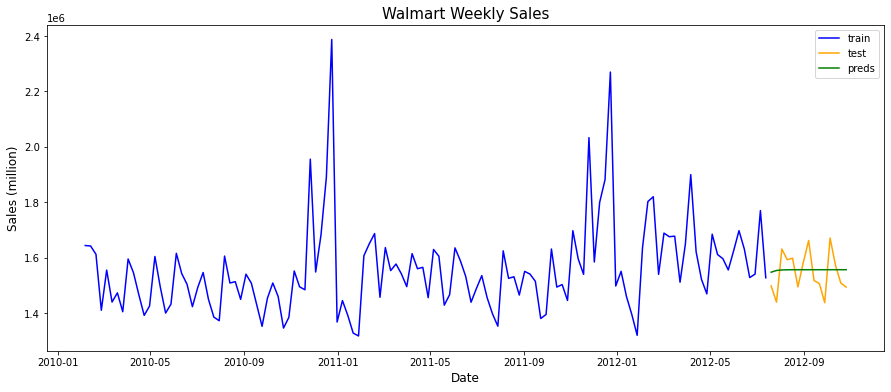

In [31]:
plot_predict(train, test, test_preds)

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [32]:
# From plotting, the model does not perform well. Looking at predictions (green line)
# We will see that the model predicted alomost the same level of same for every predicted weeks.

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [33]:
# Instantiate ARIMA model
arima = ARIMA(endog=train, order=(2, 0, 2))

# Fit model
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [34]:
train_preds = model.predict(start=train.index[0], end=train.index[-1])
test_preds = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [35]:
print('Testing MSE:', mean_squared_error(test, test_preds))

Testing MSE: 4617987711.367902


**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

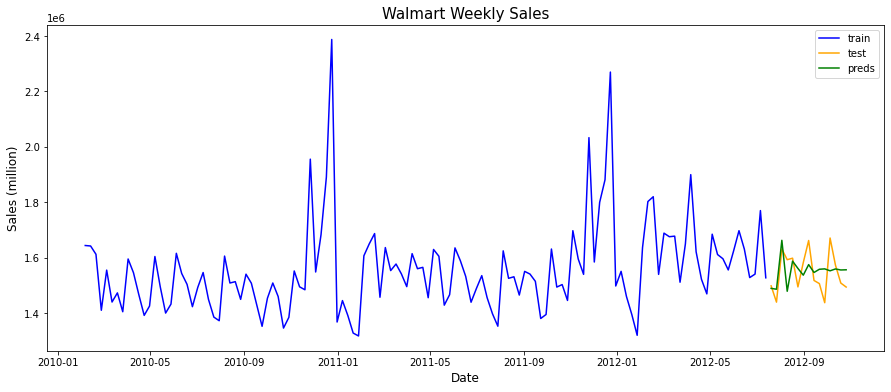

In [36]:
plot_predict(train, test, test_preds)

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [37]:
# This model is better than previous model. First half of predictions
# go along with actual test set but second half of the predictions, the model predicted
# similar values without fluctuation.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [38]:
# Instantiate ARIMA model
arima = ARIMA(endog=train, order=(2, 1, 2))

# Fit model
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [39]:
train_preds = model.predict(start=train.index[0], end=train.index[-1])
test_preds = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [40]:
print('Testing MSE:', mean_squared_error(test, test_preds))

Testing MSE: 8383610308.901479


**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

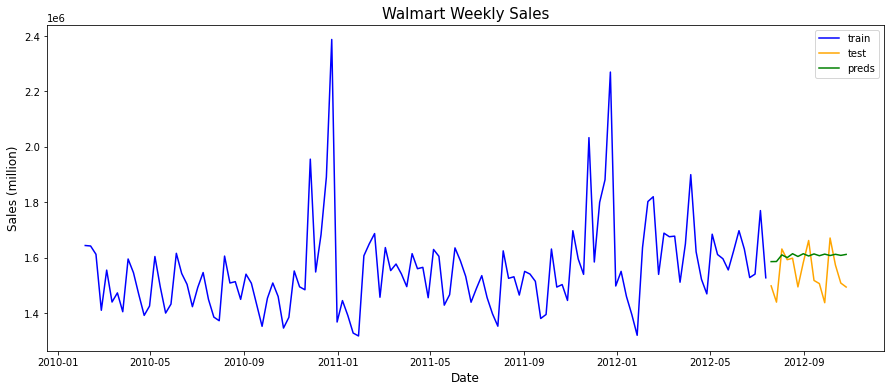

In [41]:
plot_predict(train, test, test_preds)

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [42]:
# This models does not perform well. The model predictions always predict almost the highest
# value of test data.

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [43]:
# Instantiate ARIMA model
arima = ARIMA(endog=train, order=(52, 0, 1))

# Fit model
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [44]:
train_preds = model.predict(start=train.index[0], end=train.index[-1])
test_preds = model.predict(start=test.index[0], end=test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [45]:
print('Testing MSE:', mean_squared_error(test, test_preds))

Testing MSE: 7893345443.142667


**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

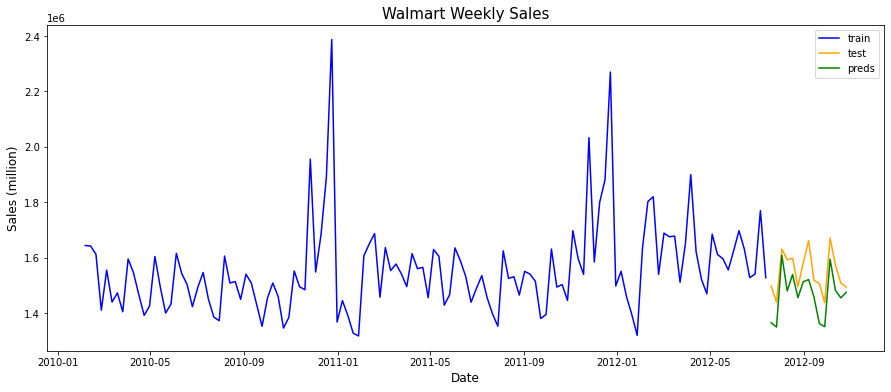

In [46]:
plot_predict(train, test, test_preds)

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [47]:
# From plotting, comparing test data and predictions, prediction line go along with test data line.
# However, the model of order (2,0,2) is better comparing by MSE.

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

Testing MSE: 1888756006.6492727


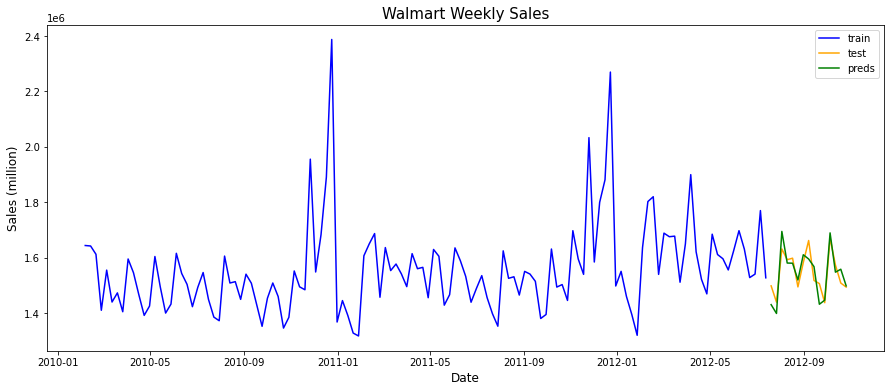

In [48]:
# instantiate
sarima = SARIMAX( endog=train,
                  order=(2, 0, 2),              
                  seasonal_order=(1, 1, 1, 52) 
                )

# fit
model = sarima.fit(disp=0)

# predict
train_preds = model.predict(start=train.index[0], end=train.index[-1])
test_preds = model.predict(start=test.index[0], end=test.index[-1])

# evaluate
print('Testing MSE:', mean_squared_error(test, test_preds))

# plot
plot_predict(train, test, test_preds)

In [49]:
# The model perfrom really well comparing with all ARIMA models.
# MSE is about 4 times lower than the lowest MSE of AIMA model.
# Also, from chart, prediction line is go along very well with test data line.